<h1><center>Global stuff</center></h1>

In [1]:
# Eases updating libs
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy
import pygsp
import os
import matplotlib.pyplot as pyplot

In [3]:
# Random seed
numpy.random.seed(0)

In [4]:
# Useful constants
OUTPUT_DIR = "output/"

<h1><center>Functions</center></h1>

In [5]:
"""
    Creates the directory for the given file name if it does not exist.
    --
    In:
        * file_name: Directory to create, or file for which we want to create a directory.
    Out:
        * None.
"""

def create_directory_for (file_name) :
    
    # Creates the corresponding directory
    dir_name = os.path.dirname(file_name)
    os.makedirs(dir_name, exist_ok=True)

In [6]:
"""
    Creates a path graph.
    --
    In:
        * graph_order: Number of vertices.
    Out:
        * graph: A PyGSP path graph.
"""

def create_path_graph (graph_order) :
    
    # PyGSP function
    graph = pygsp.graphs.Path(graph_order)
    graph.compute_fourier_basis()
    return graph

In [7]:
"""
    Creates a stochastic block model.
    --
    In:
        * graph_order: Number of vertices.
    Out:
        * graph: A PyGSP path graph.
"""

def create_sbm_graph (graph_order) :
    
    # PyGSP function
    groups = numpy.array([0] * (graph_order//3) + [1] * (graph_order//3) + [2] * (graph_order-2*graph_order//3))
    graph = pygsp.graphs.StochasticBlockModel(graph_order, k=3, z=groups, p=[0.4, 0.6, 0.3], q=0.02)
    graph.set_coordinates(kind="spring", seed=numpy.random.randint(2**32))
    graph.compute_fourier_basis()
    return graph

In [8]:
"""
    Creates a sensor graph.
    --
    In:
        * graph_order: Number of vertices.
    Out:
        * graph: A PyGSP sensor graph.
"""

def create_sensor_graph (graph_order) :
    
    # PyGSP function
    graph = pygsp.graphs.Sensor(graph_order, seed=numpy.random.randint(2**32))
    graph.compute_fourier_basis()
    return graph

In [9]:
"""
    Plots a PyGSP graph.
    --
    In:
        * graph: Graph to plot.
        * signal: Signal to plot on vertices.
        * title: Figure title.
        * file_name: Where to save the results.
    Out:
        * None.
"""

def plot_graph (graph, signal=None, title="", file_name=None) :
    
    # With or without signal
    figure = pyplot.figure(figsize=(20, 10))
    if signal is None :
        graph.plot(ax=figure.gca())
    else :
        graph.plot_signal(signal, ax=figure.gca())
    
    # Plot
    pyplot.title(title)
    pyplot.axis("off")
    pyplot.tight_layout()
    pyplot.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name)

In [10]:
"""
    Plots a matrix.
    --
    In:
        * matrix: Matrix to plot.
        * rows_labels: Labels associated with the rows.
        * cols_labels: Labels associated with the columns.
        * title: Figure title.
        * colorbar: Set to True to plot a colorbar.
        * round_values: Set to >= 0 to plot values in matrix cells.
        * file_name: Where to save the results.
    Out:
        * None.
"""

def plot_matrix (matrix, rows_labels="", cols_labels="", rows_title="", cols_title="", title="", colorbar=False, round_values=None, file_name=None) :

    # Plot matrix
    figure, axis = pyplot.subplots(figsize=(20, 20))
    cax = axis.matshow(matrix)
    
    # Add colorbar
    if colorbar :
        pyplot.colorbar(cax)
    
    # Add values
    if round_values is not None :
        color_change_threshold = 0.5 * (numpy.max(matrix) + numpy.min(matrix))
        for i in range(matrix.shape[0]) :
            for j in range(matrix.shape[1]) :
                value = round(matrix[i, j], round_values) if round_values > 0 else int(matrix[i, j])
                color = "black" if matrix[i, j] > color_change_threshold else "white"
                axis.text(j, i, str(value), va="center", ha="center", color=color)
    
    # Plot
    pyplot.title(title)
    pyplot.yticks(range(matrix.shape[0]))
    pyplot.ylabel(rows_title)
    pyplot.gca().set_yticklabels(rows_labels)
    pyplot.xticks(range(matrix.shape[1]))
    pyplot.xlabel(cols_title)
    pyplot.gca().set_xticklabels(cols_labels)
    pyplot.tight_layout()
    pyplot.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

In [11]:
"""
    Creates a heat kernel h = exp(-tau*lambda) on a graph.
    --
    In:
        * graph: PyGSP graph.
        * scale: Tau in kernel formula.
    Out:
        * kernel: PyGSP heat kernel.
"""

def create_heat_kernel (graph, scale) :

    # PyGSP kernel
    kernel = pygsp.filters.Heat(graph, scale, normalize=True)
    return kernel

In [12]:
"""
    Computes the spectrogram of a graph signal using a given kernel to generate the window.
    --
    In:
        * graph: PyGSP graph.
        * signal: Signal to analyze.
        * window_kernel: PyGSP Kernel to define the window.
    Out:
        * spectrogram: Spectrogram matrix.
"""

def compute_graph_spectrogram (graph, signal, window_kernel) :
    
    # We localize the window everywhere and report the frequencies
    spectrogram = numpy.zeros((graph.N, graph.N))
    for i in range(graph.N) :
        window = window_kernel.localize(i)
        windowed_signal = window * signal
        spectrogram[:, i] = graph.gft(windowed_signal) ** 2
    return spectrogram

In [13]:
"""
    Returns the neighbors of a vertex in a graph.
    --
    In:
        * graph: PyGSP graph.
        * vertex: Vertex for which to get neighbors.
    Out:
        * neighbors: A list of neighbors of the give vertex.
"""

def get_neighbors (graph, vertex) :
    
    # We get the neighbors in the graph
    neighbors = list(graph.W[vertex].nonzero()[1])
    return neighbors

<h1><center>Recreation of https://arxiv.org/pdf/1307.5708.pdf</center></h1>

In [14]:
# Constants
GRAPH_ORDER = 100
KERNEL_SCALE = 300

In [15]:
# Let's work on a path graph
graph = create_path_graph(GRAPH_ORDER)

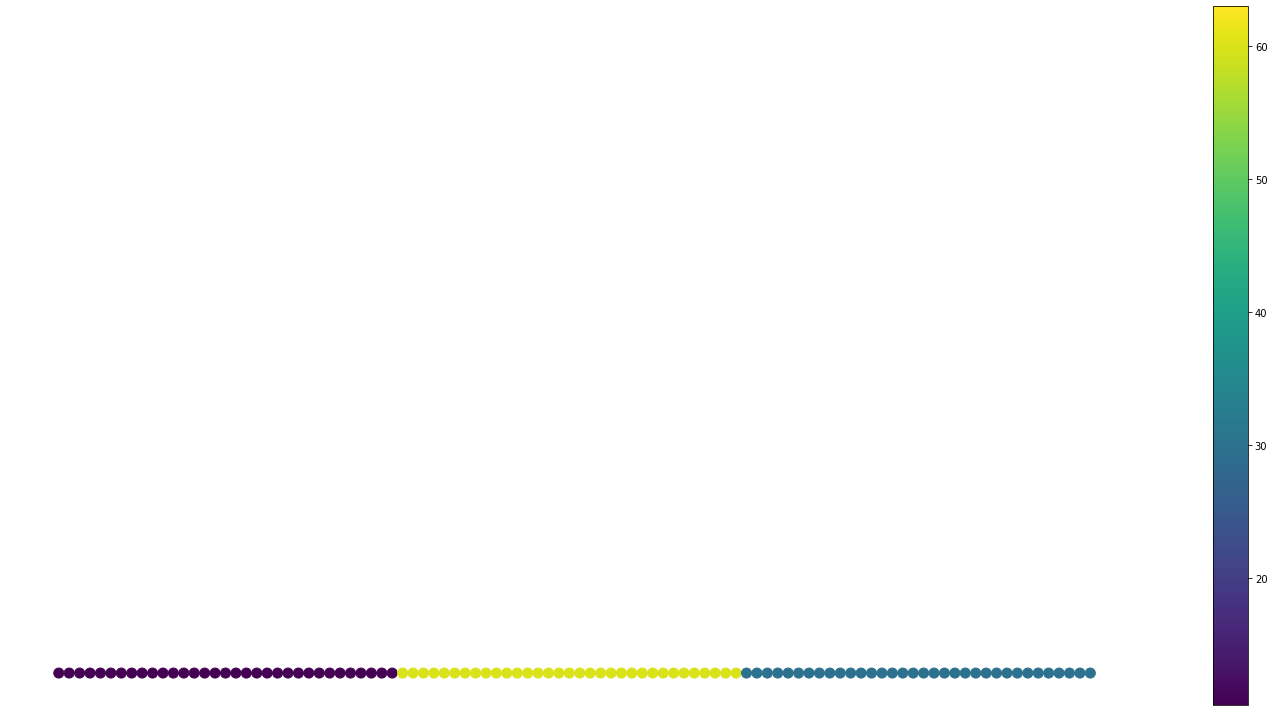

In [16]:
# We create 3 groups of vertices
groups = numpy.array([10] * (graph.N//3) +
                     [60] * (graph.N//3) +
                     [30] * (graph.N-2*graph.N//3))

# Plot
plot_graph(graph, groups)

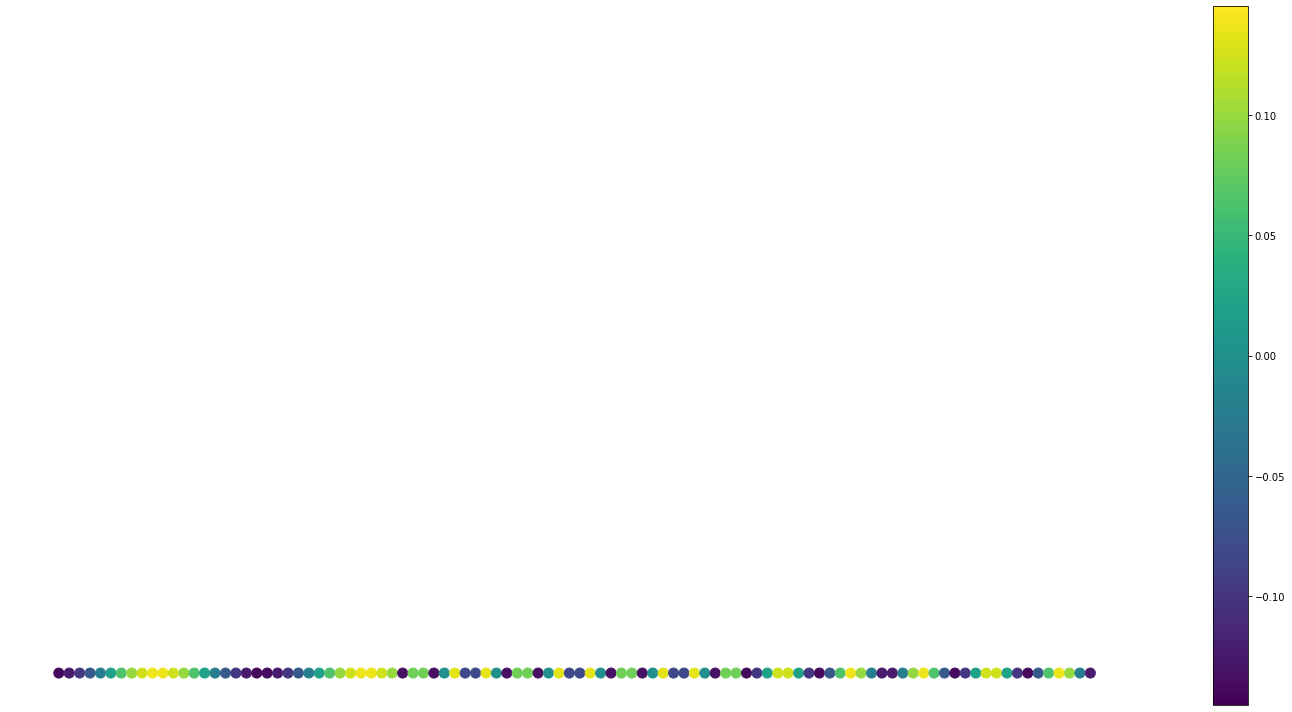

In [17]:
# Signal to analyze is a mix between some frequencies
x = numpy.array([graph.U[i, int(groups[i])] for i in range(graph.N)])
x /= numpy.linalg.norm(x)

# Plot
plot_graph(graph, x)

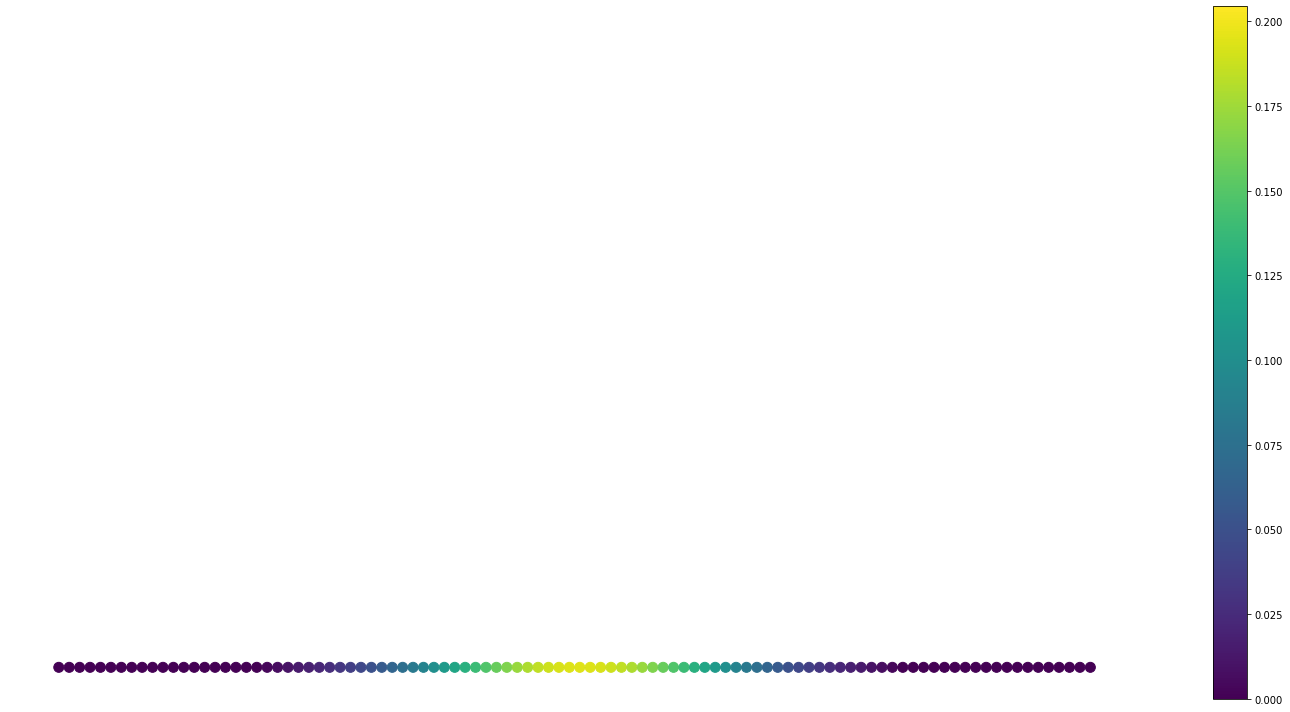

In [18]:
# We use a window defined by a heat kernel
# Needs to be instanciated on a particular vertex to be the object we want
window_kernel = create_heat_kernel(graph, KERNEL_SCALE)
localized_kernel = window_kernel.localize(int(graph.N/2))

# Plot
plot_graph(graph, localized_kernel)

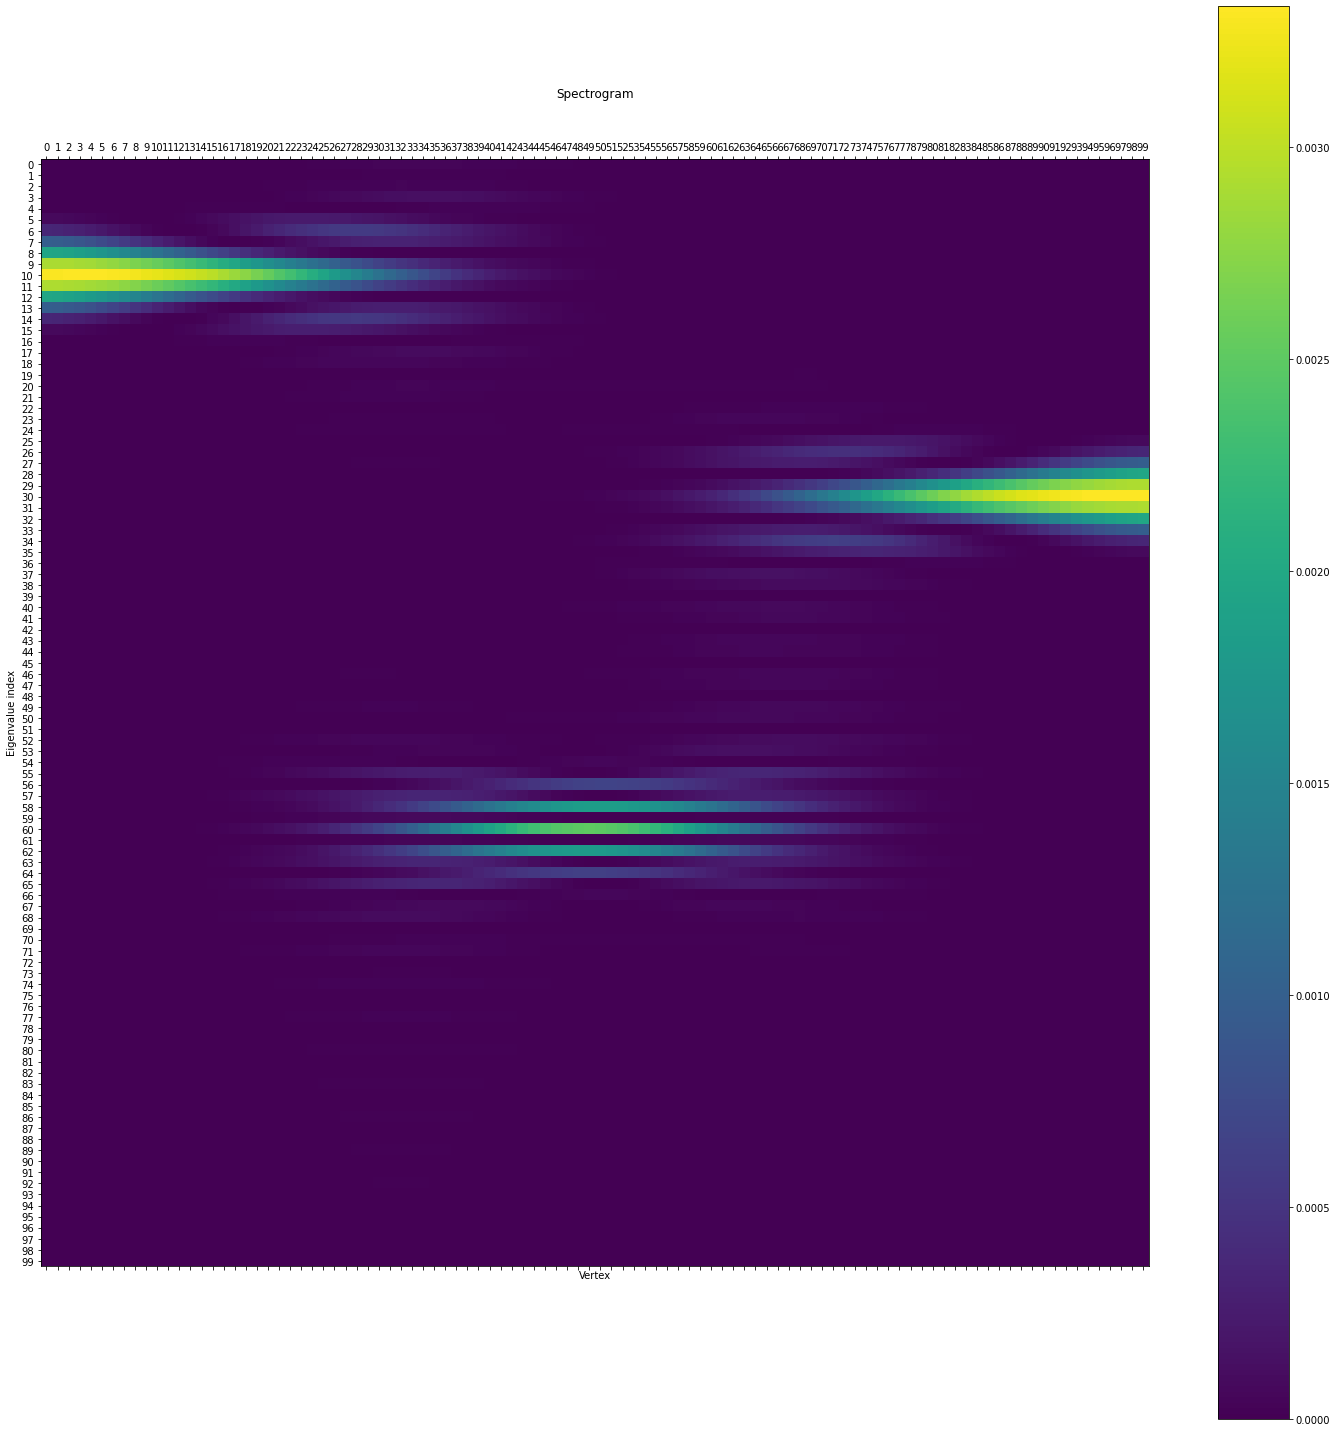

In [19]:
# Graph spectrogram of the signal
spectrogram = compute_graph_spectrogram(graph, x, window_kernel)

# Plot
plot_matrix(spectrogram,
            cols_title="Vertex",
            cols_labels=range(graph.N),
            rows_title="Eigenvalue index",
            rows_labels=range(graph.N),
            title="Spectrogram",
            colorbar=True)

<h1><center>Same with a stochastic block model</center></h1>

In [20]:
# Constants
GRAPH_ORDER = 100
KERNEL_SCALE = 10

In [21]:
# Let's work on a SBM
graph = create_sbm_graph(GRAPH_ORDER)

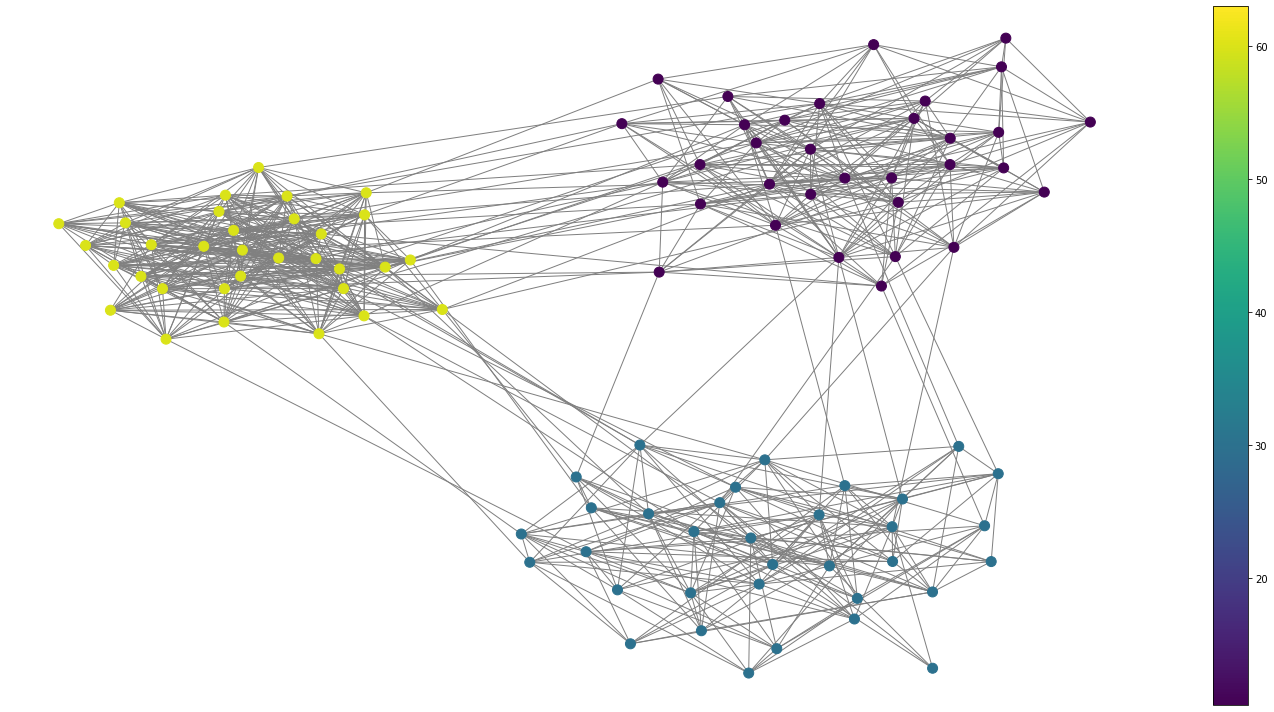

In [22]:
# We create 3 groups of vertices
# Same as those in SBM definition
groups = numpy.array([10] * (graph.N//3) + [60] * (graph.N//3) + [30] * (graph.N-2*graph.N//3))

# Plot
plot_graph(graph, groups)

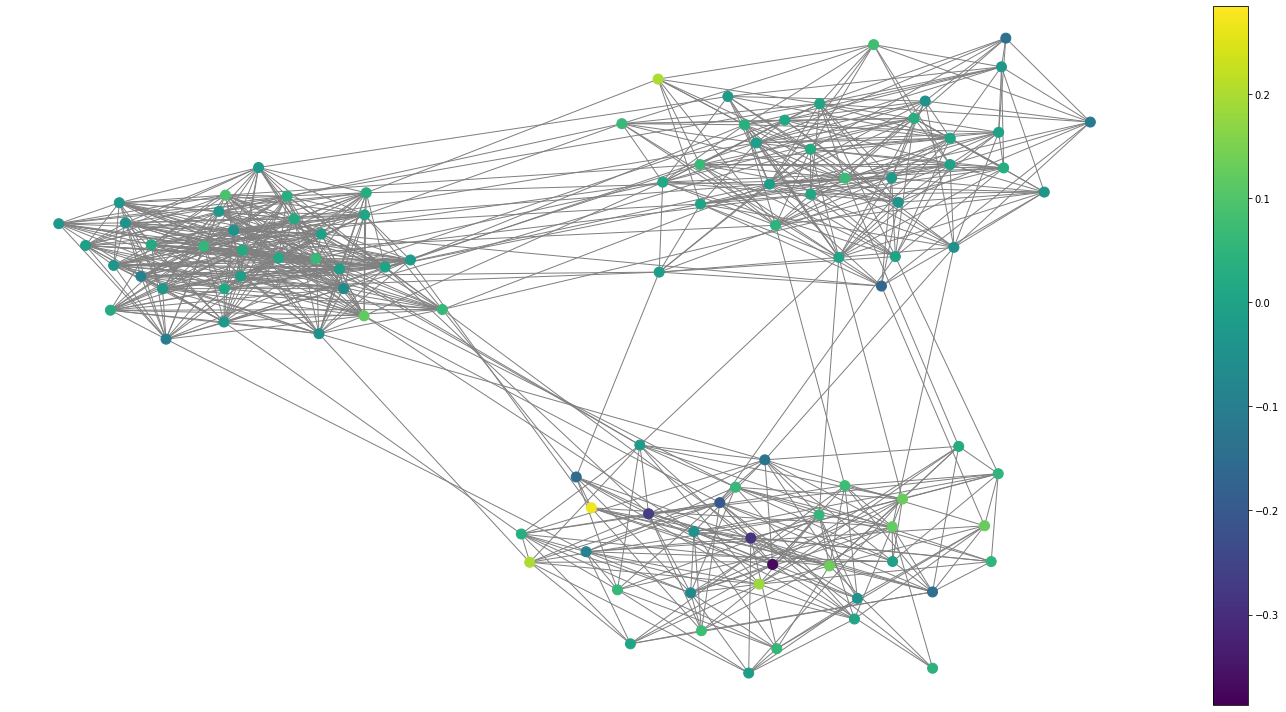

In [27]:
# Signal to analyze is a mix between some frequencies
x = numpy.array([graph.U[i, int(groups[i])] for i in range(graph.N)])
x /= numpy.linalg.norm(x)

# Plot
plot_graph(graph, x)

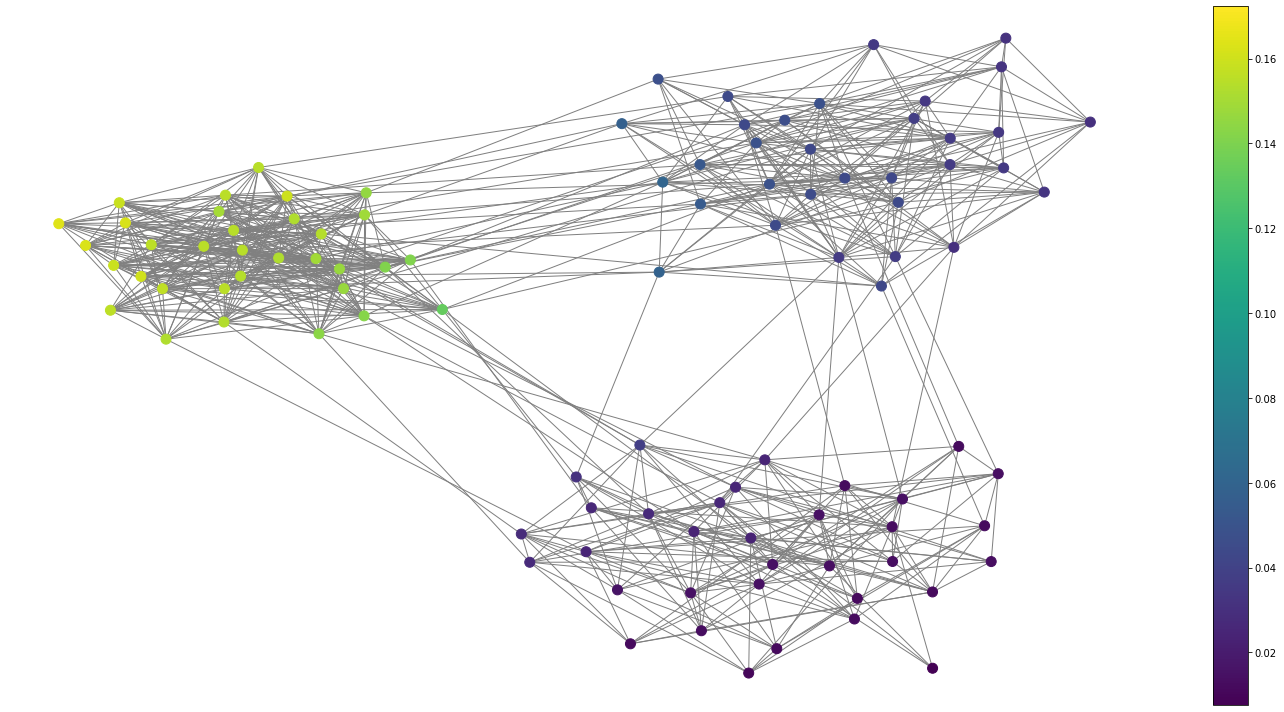

In [28]:
# We use a window defined by a heat kernel
# Needs to be instanciated on a particular vertex to be the object we want
window_kernel = create_heat_kernel(graph, KERNEL_SCALE)
localized_kernel = window_kernel.localize(graph.N//2)

# Plot
plot_graph(graph, localized_kernel)

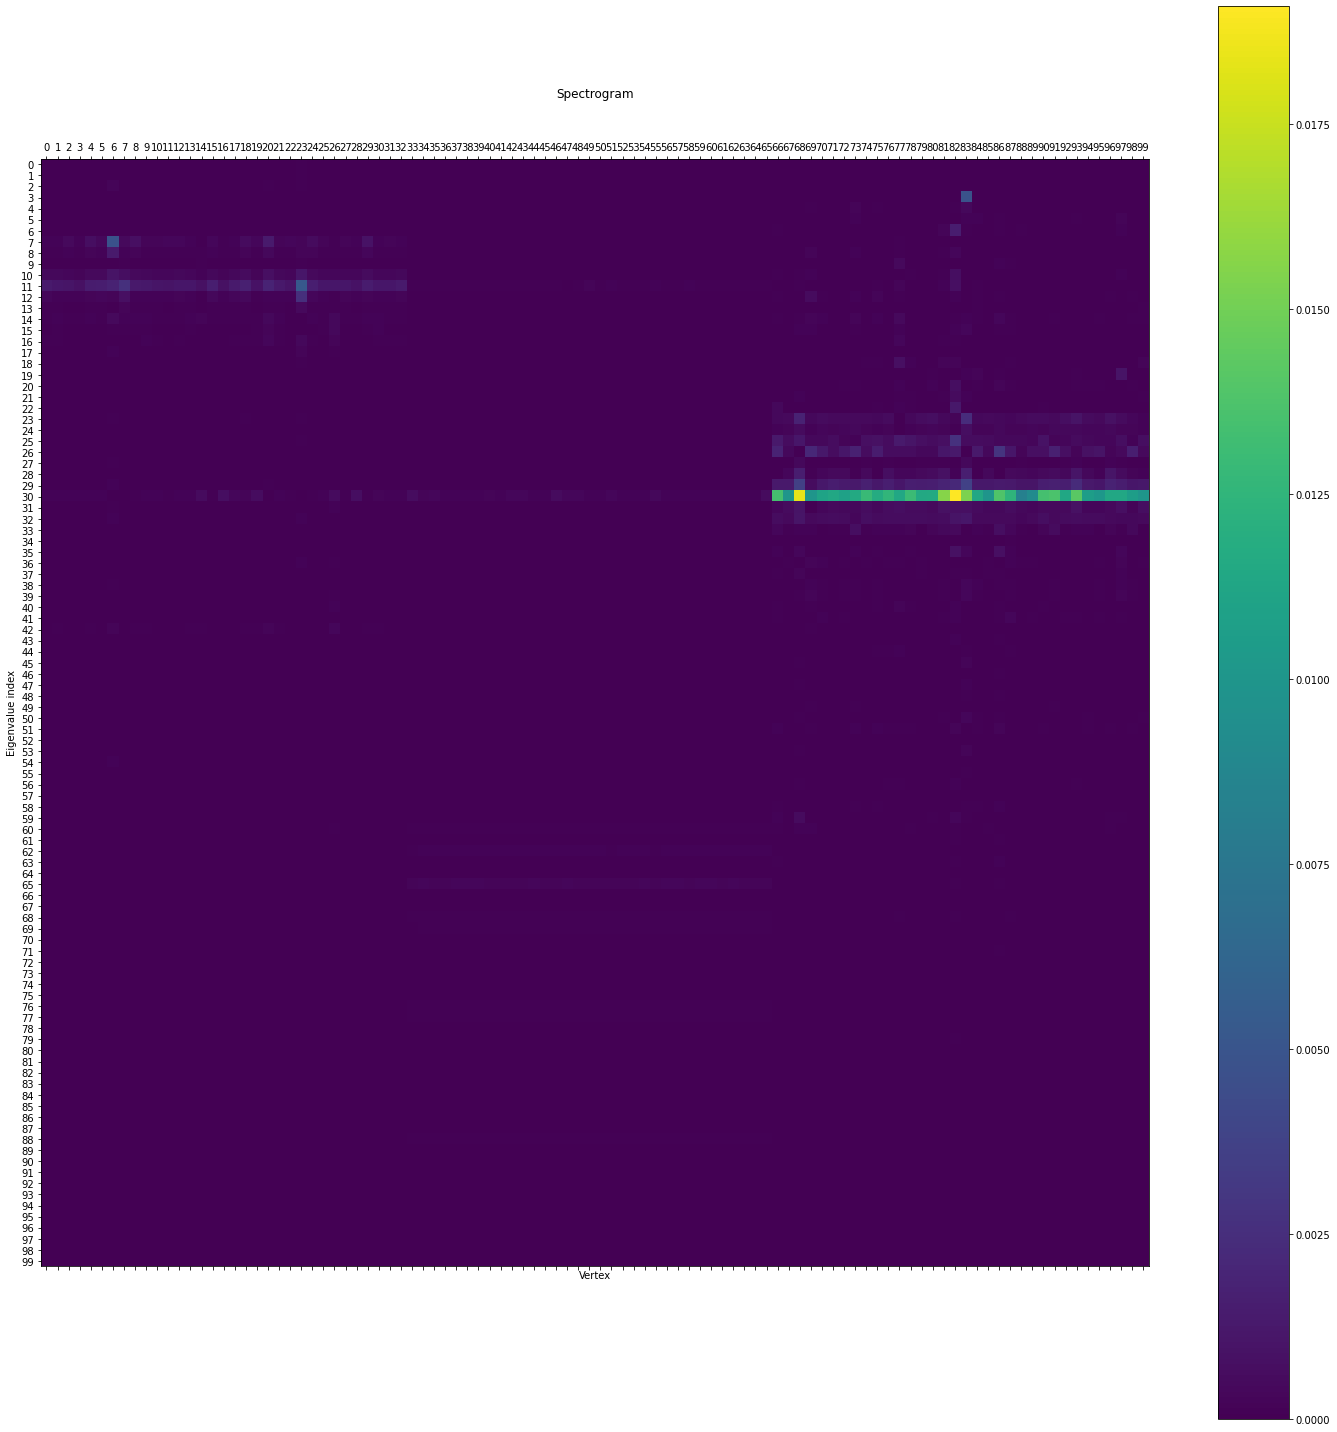

In [29]:
# Graph spectrogram of the signal
spectrogram = compute_graph_spectrogram(graph, x, window_kernel)

# Plot
plot_matrix(spectrogram,
            cols_title="Vertex",
            cols_labels=range(graph.N),
            rows_title="Eigenvalue index",
            rows_labels=range(graph.N),
            title="Spectrogram",
            colorbar=True,
            file_name=OUTPUT_DIR + "tmp.png")